## Autoencoders to sample the contact matrices 

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim 
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [10]:
names = ['Albania', 'Algeria', 'Andorra', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria',
         'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
         'Bolivia (Plurinational State of', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei Darussalam',
         'Bulgaria', 'Burkina Faso', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Chile', 'China', 'Colombia',
         'Congo', 'Costa Rica', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Dominican Republic', 'Ecuador',
         'Egypt', 'El Salvador', 'Estonia', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Georgia', 'Germany', 'Ghana',
         'Greece', 'Guatemala', 'Guinea', 'Guyana', 'Haiti', 'Honduras', 'Hong Kong SAR, China', 'Hungary',
         'Iceland', 'India', 'Indonesia', 'Iran (Islamic Republic of)', 'Iraq', 'Ireland', 'Israel', 'Italy',
         'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kiribati', 'Kuwait', 'Kyrgyzstan',
         "Lao People's Democratic Republi", 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Lithuania', 'Luxembourg',
         'Malaysia', 'Maldives', 'Malta', 'Mauritania', 'Mauritius', 'Mexico', 'Monaco', 'Mongolia', 'Montenegro',
         'Morocco', 'Mozambique', 'Namibia', 'Nepal', 'Netherlands', 'New Zealand', 'Nicaragua', 'Niger', 'Nigeria',
         'Oman', 'Pakistan', 'Panama', 'Paraguay', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Qatar',
         'Republic of Korea', 'Romania', 'Russian Federation', 'Rwanda', 'Saint Lucia', 'Samoa',
         'Sao Tome and Principe ', 'Saudi Arabia', 'Senegal', 'Serbia', 'Seychelles', 'Sierra Leone', 'Singapore',
         'Slovakia', 'Slovenia', 'Solomon Islands', 'South Africa', 'Spain', 'Sri Lanka', 'Suriname', 'Sweden',
         'Switzerland', 'Syrian Arab Republic', 'Taiwan', 'Tajikistan', 'TFYR of Macedonia', 'Thailand',
         'Timor-Leste', 'Tonga', 'Tunisia', 'Turkey', 'Uganda', 'Ukraine', 'United Arab Emirates',
         'United Kingdom of Great Britain', 'United Republic of Tanzania', 'United States of America', 'Uruguay',
         'Uzbekistan', 'Vanuatu', 'Venezuela (Bolivarian Republic ', 'Viet Nam', 'Yemen', 'Zambia', 'Zimbabwe']

### Home contacts matrices

In [11]:
def get_conts(name='Albania'):
    import sciris as sc
    obj_path_home = '../synthpops/data/MUestimates_home_1.xlsx' if name in names[:90] else '../synthpops/data/MUestimates_home_2.xlsx'
    header = 0 if name in names[:90] else None
    #obj_path_work = 'synthpops/synthpops/data/MUestimates_work.obj'
    #obj_path_school = 'synthpops/synthpops/data/MUestimates_school.obj'
    data = pd.read_excel(obj_path_home, sheet_name=name, header=header)
    return data

In [12]:
my_dict = {name: get_conts(name) for name in names}

/home/tsurkis_vi/miniconda3/envs/snakemake/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/home/tsurkis_vi/miniconda3/envs/snakemake/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/home/tsurkis_vi/miniconda3/envs/snakemake/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/home/tsurkis_vi/miniconda3/envs/snakemake/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's de

In [13]:
transform = transforms.ToTensor()
for name in names:
    my_dict[name] = transform(my_dict[name].values.T.reshape(-1, 16 * 16))

In [14]:
transform = transforms.ToTensor()

In [15]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        self.encoder = nn.Sequential(
            nn.Linear(16 * 16, 6 * 6),
            nn.ReLU(),
            nn.Linear(6 * 6, 1 * 1),
            nn.Tanh()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(1 * 1, 6 * 6),
            nn.ReLU(),
            nn.Linear(6 * 6, 16 * 16),
            nn.ReLU()
        )

    def encode(self, x):
        return self.encoder(x)

    def decode(self, y):
        return self.decoder(y)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [16]:
home_model = Autoencoder()
home_model.double()
criterion = nn.MSELoss()
optimizer = optim.Adam(home_model.parameters(), lr=5e-4, weight_decay=1e-5)

In [17]:
num_epochs = 100
outputs = []
for epoch in range(num_epochs):
    loss_arr = []
    for name in names[:140]:
        img = my_dict[name].reshape(-1, 16 * 16) 
        recon = home_model(img)
        loss = criterion(recon, img)
        loss_arr.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_avg = np.mean(loss_arr)
    
    loss_arr = []
    for name in names[140:]:
        img = my_dict[name].reshape(-1, 16 * 16)
        recon = home_model(img)
        loss = criterion(recon, img)
        loss_arr.append(loss.item())
    loss_test = np.mean(loss_arr)
    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append([epoch, img, recon, loss_avg, loss_test])
    
# torch.save(home_model.state_dict(), 'models/new_model.txt')
# model.load_state_dict(torch.load('models/model_for_household_matrices.txt'))

Epoch:1, Loss:0.0483
Epoch:2, Loss:0.0402
Epoch:3, Loss:0.0304
Epoch:4, Loss:0.0268
Epoch:5, Loss:0.0267
Epoch:6, Loss:0.0241
Epoch:7, Loss:0.0216
Epoch:8, Loss:0.0212
Epoch:9, Loss:0.0212
Epoch:10, Loss:0.0212
Epoch:11, Loss:0.0212
Epoch:12, Loss:0.0212
Epoch:13, Loss:0.0212
Epoch:14, Loss:0.0201
Epoch:15, Loss:0.0182
Epoch:16, Loss:0.0172
Epoch:17, Loss:0.0172
Epoch:18, Loss:0.0172
Epoch:19, Loss:0.0122
Epoch:20, Loss:0.0082
Epoch:21, Loss:0.0050
Epoch:22, Loss:0.0049
Epoch:23, Loss:0.0048
Epoch:24, Loss:0.0048
Epoch:25, Loss:0.0048
Epoch:26, Loss:0.0049
Epoch:27, Loss:0.0049
Epoch:28, Loss:0.0049
Epoch:29, Loss:0.0049
Epoch:30, Loss:0.0049
Epoch:31, Loss:0.0049
Epoch:32, Loss:0.0049
Epoch:33, Loss:0.0049
Epoch:34, Loss:0.0049
Epoch:35, Loss:0.0049
Epoch:36, Loss:0.0049
Epoch:37, Loss:0.0050
Epoch:38, Loss:0.0050
Epoch:39, Loss:0.0050
Epoch:40, Loss:0.0050
Epoch:41, Loss:0.0050
Epoch:42, Loss:0.0050
Epoch:43, Loss:0.0050
Epoch:44, Loss:0.0050
Epoch:45, Loss:0.0051
Epoch:46, Loss:0.00

In [18]:
arr_hist = [[], []]
with open('history/history_26_08.txt') as data:
    for line in data:
        train, test = line.strip().split()
        arr_hist[0].append(float(train))
        arr_hist[1].append(float(test))

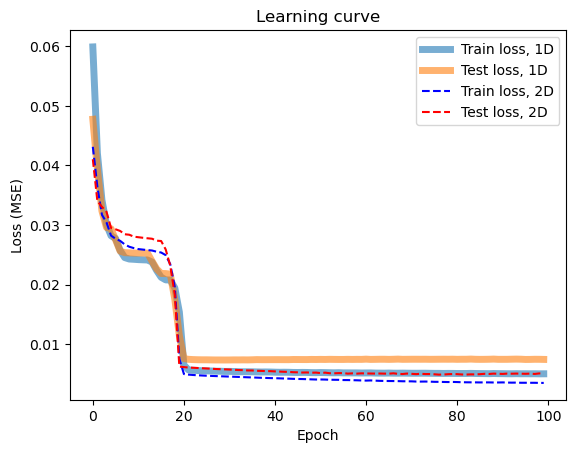

In [19]:
plt.plot([element[3] for element in outputs], linewidth=5, alpha=0.6, label='Train loss, 1D')
plt.plot([element[4] for element in outputs], linewidth=5, alpha=0.6, label='Test loss, 1D')
plt.plot(arr_hist[0], color='blue', linestyle='--', label='Train loss, 2D')
plt.plot(arr_hist[1], color='red', linestyle='--', label='Test loss, 2D')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Learning curve')
plt.legend()
plt.show()

In [29]:
home_model = Autoencoder()
home_model.load_state_dict(torch.load('models/model_for_home_1D_28_08.txt'))
home_model.double()

/tmp/ipykernel_3992162/1594070589.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  home_model.load_state_dict(torch.load('models/model_for_home_1D_28_08.txt'))


Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=256, out_features=36, bias=True)
    (1): ReLU()
    (2): Linear(in_features=36, out_features=1, bias=True)
    (3): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=1, out_features=36, bias=True)
    (1): ReLU()
    (2): Linear(in_features=36, out_features=256, bias=True)
    (3): ReLU()
  )
)

In [38]:
african_countries = [
    'Burundi',
    'Comoros',
    'Djibouti',
    'Eritrea',
    'Ethiopia',
    'Kenya',
    'Madagascar',
    'Malawi',
    'Mauritius',
    'Mayotte',
    'Mozambique',
    'Réunion',
    'Rwanda',
    'Seychelles',
    'Somalia',
    'South Sudan',
    'Uganda',
    'United Republic of Tanzania',
    'Zambia',
    'Zimbabwe',
    'Angola',
    'Cameroon',
    'Central African Republic',
    'Chad',
    'Congo',
    'Democratic Republic of the Congo',
    'Equatorial Guinea',
    'Gabon',
    'Sao Tome and Principe',
    'Algeria',
    'Egypt',
    'Libya',
    'Morocco',
    'Sudan',
    'Tunisia',
    'Western Sahara',
    'Botswana',
    'Eswatini',
    'Lesotho',
    'Namibia',
    'South Africa',
    'Benin',
    'Burkina Faso',
    'Cabo Verde',
    "Côte d'Ivoire",
    'Gambia',
    'Ghana',
    'Guinea',
    'Guinea-Bissau',
    'Liberia',
    'Mali',
    'Mauritania',
    'Niger',
    'Nigeria',
    'Saint Helena',
    'Senegal',
    'Sierra Leone',
    'Togo'
]

In [41]:
home_arr_vectors = []
for name in [name for name in names if name not in african_countries]:
    encoded = home_model.encode(my_dict[name]).detach().numpy()[0][0]
    home_arr_vectors.append(encoded)
    if encoded  < -0.3:
        print(encoded, name)

[-0.56964929] Belgium
[-0.57430365] Finland
[-0.48083253] Italy
[-0.70234809] Luxembourg
[-0.9888304] Poland


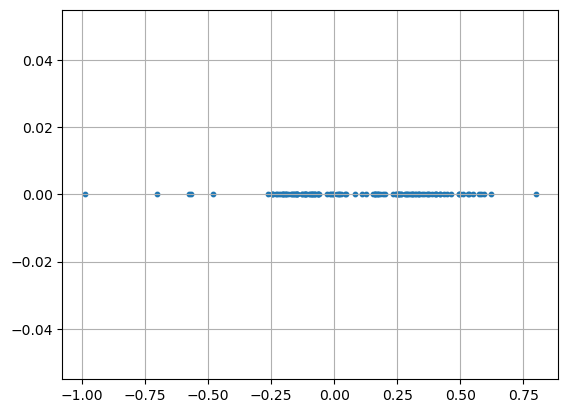

In [42]:
plt.grid()
plt.scatter(home_arr_vectors, [0 for element in home_arr_vectors], s=10)

### Range for the sampling:

In [43]:
np.percentile(home_arr_vectors, [5, 95])

array([-0.24568056,  0.53609986])

### Work contacts matrices

In [33]:
def get_work_conts(name='Albania'):
    import sciris as sc
    obj_path_home = '../synthpops/data/MUestimates_work_1.xlsx' if name in names[:90] else '../synthpops/data/MUestimates_work_2.xlsx'
    header = 0 if name in names[:90] else None
    #obj_path_work = 'synthpops/synthpops/data/MUestimates_work.obj'
    #obj_path_school = 'synthpops/synthpops/data/MUestimates_school.obj'
    data = pd.read_excel(obj_path_home, sheet_name=name, header=header)
    return data

In [34]:
work_matrices = {name: get_work_conts(name) for name in names}

/home/tsurkis_vi/miniconda3/envs/snakemake/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/home/tsurkis_vi/miniconda3/envs/snakemake/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/home/tsurkis_vi/miniconda3/envs/snakemake/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/home/tsurkis_vi/miniconda3/envs/snakemake/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's de

/home/tsurkis_vi/miniconda3/envs/snakemake/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/home/tsurkis_vi/miniconda3/envs/snakemake/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/home/tsurkis_vi/miniconda3/envs/snakemake/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/home/tsurkis_vi/miniconda3/envs/snakemake/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's de

In [35]:
for name in names:
    work_matrices[name] = transform(work_matrices[name].values.T.reshape(-1, 16 * 16))

In [36]:
work_model = Autoencoder()
work_model.double()
criterion = nn.MSELoss()
optimizer = optim.Adam(work_model.parameters(), lr=5e-5, weight_decay=1e-5)

In [44]:
num_epochs = 150
work_outputs = []
for epoch in range(num_epochs):
    loss_arr = []
    for name in names[:140]:
        img = work_matrices[name].reshape(-1, 16 * 16) # -> use for Autoencoder_Linear
        recon = work_model(img)
        loss = criterion(recon, img)
        loss_arr.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_avg = np.mean(loss_arr)

    loss_arr = []
    for name in names[140::]:
        img = work_matrices[name].reshape(-1, 16 * 16) # -> use for Autoencoder_Linear
        recon = work_model(img)
        loss = criterion(recon, img)
        loss_arr.append(loss.item())
    loss_test = np.mean(loss_arr)

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    work_outputs.append((epoch, img, recon, loss_avg, loss_test))

# torch.save(work_model.state_dict(), 'models/new_model.txt')
# work_model.load_state_dict(torch.load('models/model_for_work_matrices.txt'))

Epoch:1, Loss:0.0463
Epoch:2, Loss:0.0463
Epoch:3, Loss:0.0463
Epoch:4, Loss:0.0463
Epoch:5, Loss:0.0463
Epoch:6, Loss:0.0463
Epoch:7, Loss:0.0459
Epoch:8, Loss:0.0453
Epoch:9, Loss:0.0447
Epoch:10, Loss:0.0437
Epoch:11, Loss:0.0434
Epoch:12, Loss:0.0433
Epoch:13, Loss:0.0430
Epoch:14, Loss:0.0427
Epoch:15, Loss:0.0426
Epoch:16, Loss:0.0426
Epoch:17, Loss:0.0425
Epoch:18, Loss:0.0425
Epoch:19, Loss:0.0425
Epoch:20, Loss:0.0425
Epoch:21, Loss:0.0425
Epoch:22, Loss:0.0417
Epoch:23, Loss:0.0386
Epoch:24, Loss:0.0365
Epoch:25, Loss:0.0353
Epoch:26, Loss:0.0346
Epoch:27, Loss:0.0342
Epoch:28, Loss:0.0339
Epoch:29, Loss:0.0337
Epoch:30, Loss:0.0335
Epoch:31, Loss:0.0334
Epoch:32, Loss:0.0333
Epoch:33, Loss:0.0332
Epoch:34, Loss:0.0324
Epoch:35, Loss:0.0307
Epoch:36, Loss:0.0301
Epoch:37, Loss:0.0297
Epoch:38, Loss:0.0295
Epoch:39, Loss:0.0293
Epoch:40, Loss:0.0291
Epoch:41, Loss:0.0290
Epoch:42, Loss:0.0289
Epoch:43, Loss:0.0289
Epoch:44, Loss:0.0288
Epoch:45, Loss:0.0282
Epoch:46, Loss:0.02

In [45]:
arr_hist = [[], []]
with open('history/history_work_28_08.txt') as data:
    for line in data:
        train, test = line.strip().split()
        arr_hist[0].append(float(train))
        arr_hist[1].append(float(test))

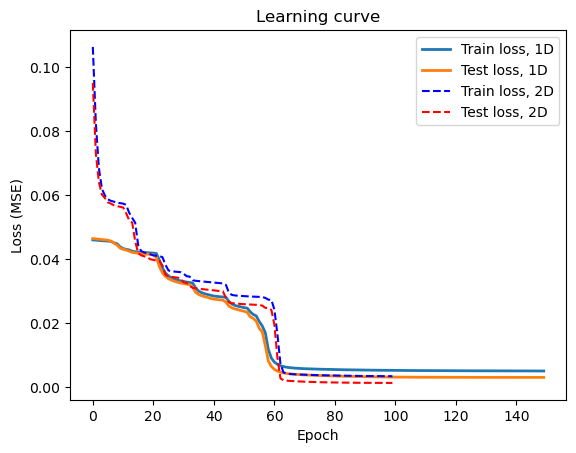

In [46]:
plt.plot([element[3] for element in work_outputs], linewidth=2, alpha=1, label='Train loss, 1D')
plt.plot([element[4] for element in work_outputs], linewidth=2, alpha=1, label='Test loss, 1D')
plt.plot(arr_hist[0], color='blue', linestyle='--', label='Train loss, 2D')
plt.plot(arr_hist[1], color='red', linestyle='--', label='Test loss, 2D')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Learning curve')
plt.legend()
plt.show()

In [47]:
work_model = Autoencoder()
work_model.load_state_dict(torch.load('models/model_for_work_1D_28_08.txt'))
work_model.double()

/tmp/ipykernel_3992162/4034906352.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  work_model.load_state_dict(torch.load('models/model_for_work_1D_28_08.txt'))


Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=256, out_features=36, bias=True)
    (1): ReLU()
    (2): Linear(in_features=36, out_features=1, bias=True)
    (3): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=1, out_features=36, bias=True)
    (1): ReLU()
    (2): Linear(in_features=36, out_features=256, bias=True)
    (3): ReLU()
  )
)

In [48]:
work_arr_vectors = []
for name in [name for name in names if name not in african_countries]:
    encoded = work_model.encode(work_matrices[name]).detach().numpy()[0][0]
    work_arr_vectors.append(encoded)
    if encoded  < -0.8:
        print(encoded, name)

[-0.86858918] Luxembourg
[-0.98208972] Netherlands


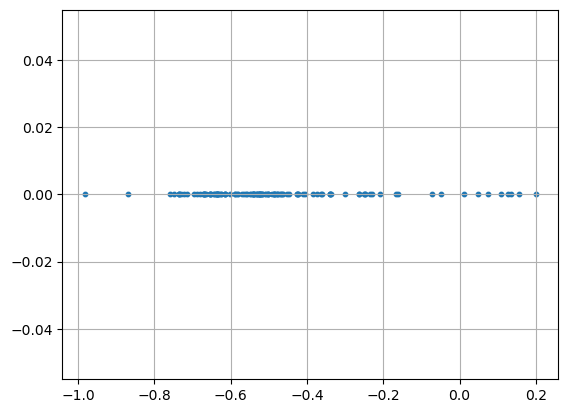

In [49]:
plt.grid()
plt.scatter(work_arr_vectors, [0 for element in home_arr_vectors], s=10)

### Range for the sampling:

In [50]:
np.percentile(work_arr_vectors, [5, 95])

array([-0.73420403,  0.04916207])

### School contacts matrices

In [51]:
def get_school_conts(name='Albania'):
    import sciris as sc
    obj_path = '../synthpops/data/MUestimates_school_1.xlsx' if name in names[:90] else '../synthpops/data/MUestimates_school_2.xlsx'
    header = 0 if name in names[:90] else None
    data = pd.read_excel(obj_path, sheet_name=name, header=header)
    return data

In [52]:
school_matrices = {name: get_school_conts(name) for name in names}

/home/tsurkis_vi/miniconda3/envs/snakemake/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


/home/tsurkis_vi/miniconda3/envs/snakemake/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/home/tsurkis_vi/miniconda3/envs/snakemake/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/home/tsurkis_vi/miniconda3/envs/snakemake/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/home/tsurkis_vi/miniconda3/envs/snakemake/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's de

In [53]:
for name in names:
    school_matrices[name] = transform(school_matrices[name].values.T.reshape(-1, 16 * 16))

In [54]:
school_model = Autoencoder()
school_model.double()
criterion = nn.MSELoss()
optimizer = optim.Adam(school_model.parameters(), lr=5e-5, weight_decay=1e-5)

In [55]:
num_epochs = 200
school_outputs = []
for epoch in range(num_epochs):
    loss_arr = []
    for name in names[:140]:
        img = school_matrices[name].reshape(-1, 16 * 16) # -> use for Autoencoder_Linear
        recon = school_model(img)
        loss = criterion(recon, img)
        loss_arr.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_avg = np.mean(loss_arr)

    loss_arr = []
    for name in names[140:]:
        img = school_matrices[name].reshape(-1, 16 * 16) # -> use for Autoencoder_Linear
        recon = school_model(img)
        loss = criterion(recon, img)
        loss_arr.append(loss.item())
    loss_test = np.mean(loss_arr)

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    school_outputs.append([epoch, img, recon, loss_avg, loss_test])

# torch.save(random_model.state_dict(), 'C:/Users/Вера/Desktop/models/model_for_random_1D_23_09.txt')
# school_model.load_state_dict(torch.load('models/model_for_school_1D_28_08.txt'))

Epoch:1, Loss:0.5340
Epoch:2, Loss:0.5277
Epoch:3, Loss:0.5235
Epoch:4, Loss:0.5205
Epoch:5, Loss:0.5114
Epoch:6, Loss:0.5033
Epoch:7, Loss:0.4968
Epoch:8, Loss:0.4910
Epoch:9, Loss:0.4779
Epoch:10, Loss:0.4642
Epoch:11, Loss:0.4527
Epoch:12, Loss:0.4423
Epoch:13, Loss:0.4324
Epoch:14, Loss:0.4229
Epoch:15, Loss:0.4137
Epoch:16, Loss:0.4045
Epoch:17, Loss:0.3954
Epoch:18, Loss:0.3864
Epoch:19, Loss:0.3776
Epoch:20, Loss:0.3685
Epoch:21, Loss:0.3597
Epoch:22, Loss:0.3509
Epoch:23, Loss:0.3423
Epoch:24, Loss:0.3338
Epoch:25, Loss:0.3254
Epoch:26, Loss:0.3171
Epoch:27, Loss:0.3090
Epoch:28, Loss:0.3010
Epoch:29, Loss:0.2933
Epoch:30, Loss:0.2857
Epoch:31, Loss:0.2784
Epoch:32, Loss:0.2712
Epoch:33, Loss:0.2643
Epoch:34, Loss:0.2576
Epoch:35, Loss:0.2512
Epoch:36, Loss:0.2451
Epoch:37, Loss:0.2391
Epoch:38, Loss:0.2335
Epoch:39, Loss:0.2281
Epoch:40, Loss:0.2229
Epoch:41, Loss:0.2181
Epoch:42, Loss:0.2134
Epoch:43, Loss:0.2091
Epoch:44, Loss:0.2049
Epoch:45, Loss:0.2010
Epoch:46, Loss:0.19

In [56]:
arr_hist = [[], []]
with open('history/history_school_28_08.txt') as data:
    for line in data:
        train, test = line.strip().split()
        arr_hist[0].append(float(train))
        arr_hist[1].append(float(test))

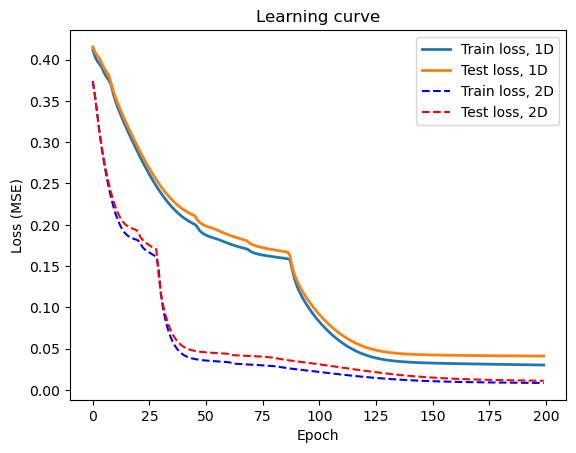

In [57]:
plt.plot([element[3] for element in school_outputs], linewidth=2, alpha=1, label='Train loss, 1D')
plt.plot([element[4] for element in school_outputs], linewidth=2, alpha=1, label='Test loss, 1D')
plt.plot(arr_hist[0], color='blue', linestyle='--', label='Train loss, 2D')
plt.plot(arr_hist[1], color='red', linestyle='--', label='Test loss, 2D')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Learning curve')
plt.legend()
plt.show()

In [58]:
school_model = Autoencoder()
school_model.load_state_dict(torch.load('models/model_for_school_1D_28_08.txt'))
school_model.double()

/tmp/ipykernel_3992162/263183361.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  school_model.load_state_dict(torch.load('models/model_for_school_1D_28_08.txt'))


Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=256, out_features=36, bias=True)
    (1): ReLU()
    (2): Linear(in_features=36, out_features=1, bias=True)
    (3): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=1, out_features=36, bias=True)
    (1): ReLU()
    (2): Linear(in_features=36, out_features=256, bias=True)
    (3): ReLU()
  )
)

In [80]:
school_arr_vectors = []
for name in [name for name in names if name not in african_countries]:
    encoded = school_model.encode(school_matrices[name]).detach().numpy()[0][0]
    school_arr_vectors.append(encoded)

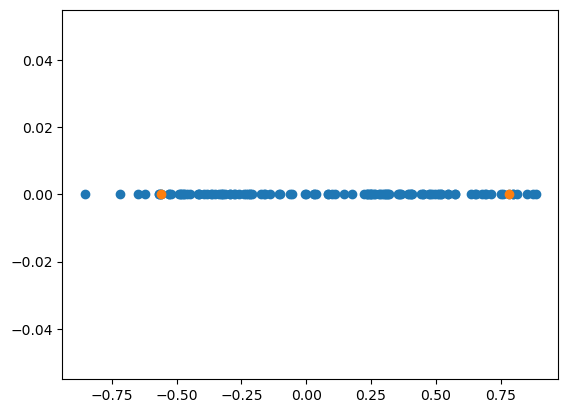

In [81]:
plt.scatter(school_arr_vectors, [0 for element in school_arr_vectors])
plt.scatter(np.percentile(school_arr_vectors, [5, 95]), [0, 0])

### Range for the sampling: 

In [82]:
np.percentile(school_arr_vectors, [5, 95])

array([-0.56119067,  0.78237624])

### Random contacts matrices

In [62]:
def get_random_conts(name='Albania'):
    import sciris as sc
    obj_path = '../synthpops/data/MUestimates_other_locations_1.xlsx' if name in names[:90] else '../synthpops/data/MUestimates_other_locations_2.xlsx'
    header = 0 if name in names[:90] else None
    data = pd.read_excel(obj_path, sheet_name=name, header=header)
    return data

In [63]:
random_matrices = {name: get_random_conts(name) for name in names}

/home/tsurkis_vi/miniconda3/envs/snakemake/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/home/tsurkis_vi/miniconda3/envs/snakemake/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/home/tsurkis_vi/miniconda3/envs/snakemake/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/home/tsurkis_vi/miniconda3/envs/snakemake/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's de

/home/tsurkis_vi/miniconda3/envs/snakemake/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/home/tsurkis_vi/miniconda3/envs/snakemake/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/home/tsurkis_vi/miniconda3/envs/snakemake/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/home/tsurkis_vi/miniconda3/envs/snakemake/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's de

In [64]:
for name in names:
    random_matrices[name] = transform(random_matrices[name].values.T.reshape(-1, 16 * 16))

In [65]:
random_model = Autoencoder()
random_model.double()
criterion = nn.MSELoss()
optimizer = optim.Adam(random_model.parameters(), lr=1e-4, weight_decay=1e-5)

In [66]:
num_epochs = 200
random_outputs = []
for epoch in range(num_epochs):
    loss_arr = []
    for name in names[:140]:
        img = random_matrices[name].reshape(-1, 16 * 16)
        recon = random_model(img)
        loss = criterion(recon, img)
        loss_arr.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_avg = np.mean(loss_arr)

    loss_arr = []
    for name in names[140:]:
        img = random_matrices[name].reshape(-1, 16 * 16)
        recon = random_model(img)
        loss = criterion(recon, img)
        loss_arr.append(loss.item())
    loss_test = np.mean(loss_arr)

    print(f'Epoch:{epoch+1}, Loss:{loss_test:.4f}')
    random_outputs.append([epoch, img, recon, loss_avg, loss_test])

#random_model.load_state_dict(torch.load('C:/Users/Вера/Desktop/model_for_random_matrices.txt'))

Epoch:1, Loss:0.7329
Epoch:2, Loss:0.7060
Epoch:3, Loss:0.6918
Epoch:4, Loss:0.6823
Epoch:5, Loss:0.6732
Epoch:6, Loss:0.6642
Epoch:7, Loss:0.6437
Epoch:8, Loss:0.6234
Epoch:9, Loss:0.6081
Epoch:10, Loss:0.5946
Epoch:11, Loss:0.5800
Epoch:12, Loss:0.5502
Epoch:13, Loss:0.5272
Epoch:14, Loss:0.5088
Epoch:15, Loss:0.4940
Epoch:16, Loss:0.4813
Epoch:17, Loss:0.4702
Epoch:18, Loss:0.4603
Epoch:19, Loss:0.4304
Epoch:20, Loss:0.3975
Epoch:21, Loss:0.3515
Epoch:22, Loss:0.3200
Epoch:23, Loss:0.2944
Epoch:24, Loss:0.2715
Epoch:25, Loss:0.2519
Epoch:26, Loss:0.2343
Epoch:27, Loss:0.2185
Epoch:28, Loss:0.2042
Epoch:29, Loss:0.1912
Epoch:30, Loss:0.1793
Epoch:31, Loss:0.1682
Epoch:32, Loss:0.1579
Epoch:33, Loss:0.1476
Epoch:34, Loss:0.1392
Epoch:35, Loss:0.1298
Epoch:36, Loss:0.1225
Epoch:37, Loss:0.1162
Epoch:38, Loss:0.1106
Epoch:39, Loss:0.1054
Epoch:40, Loss:0.1009
Epoch:41, Loss:0.0967
Epoch:42, Loss:0.0908
Epoch:43, Loss:0.0864
Epoch:44, Loss:0.0834
Epoch:45, Loss:0.0807
Epoch:46, Loss:0.07

In [67]:
arr_hist = [[], []]
with open('history/history_random_28_08.txt') as data:
    for line in data:
        train, test = line.strip().split()
        arr_hist[0].append(float(train))
        arr_hist[1].append(float(test))

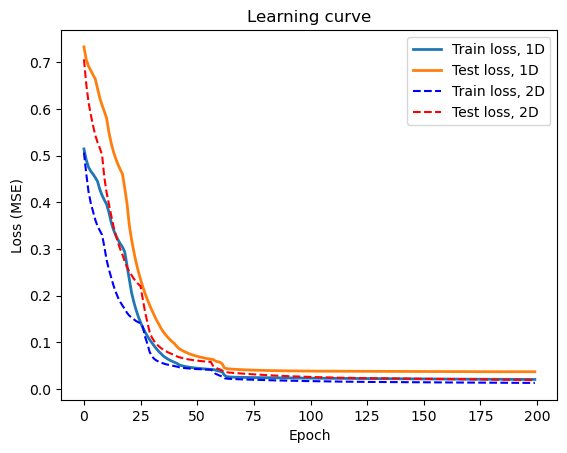

In [68]:
plt.plot([element[3] for element in random_outputs], linewidth=2, alpha=1, label='Train loss, 1D')
plt.plot([element[4] for element in random_outputs], linewidth=2, alpha=1, label='Test loss, 1D')
plt.plot(arr_hist[0], color='blue', linestyle='--', label='Train loss, 2D')
plt.plot(arr_hist[1], color='red', linestyle='--', label='Test loss, 2D')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Learning curve')
plt.legend()
plt.show()

In [69]:
random_model = Autoencoder()
random_model.load_state_dict(torch.load('models/model_for_random_1D_23_09.txt'))
random_model.double()

/tmp/ipykernel_3992162/1882654184.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  random_model.load_state_dict(torch.load('models/model_for_random_1D_23_09.txt'))


Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=256, out_features=36, bias=True)
    (1): ReLU()
    (2): Linear(in_features=36, out_features=1, bias=True)
    (3): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=1, out_features=36, bias=True)
    (1): ReLU()
    (2): Linear(in_features=36, out_features=256, bias=True)
    (3): ReLU()
  )
)

In [77]:
random_arr_vectors = []
for name in [name for name in names if name not in african_countries]:
    encoded = random_model.encode(random_matrices[name]).detach().numpy()[0][0]
    random_arr_vectors.append(encoded)

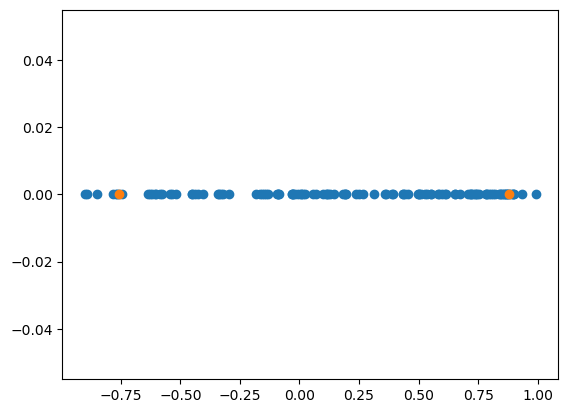

In [78]:
plt.scatter(random_arr_vectors, [0 for element in random_arr_vectors])
plt.scatter(np.percentile(random_arr_vectors, [5, 95]), [0, 0])

### Range for the sampling:

In [79]:
np.percentile(random_arr_vectors, [5, 95])

array([-0.7586837 ,  0.88089504])

### Examples of initial - rebuilt pairs (home contacts matrices)

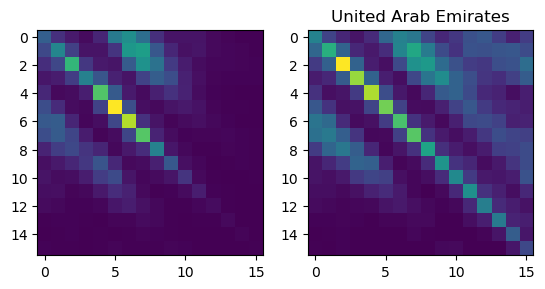

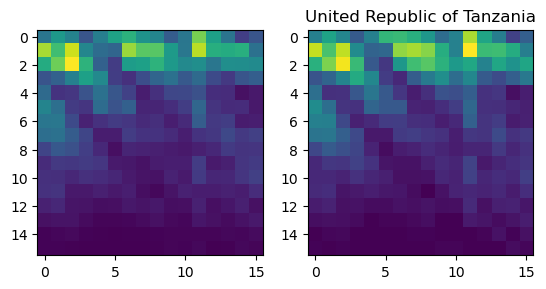

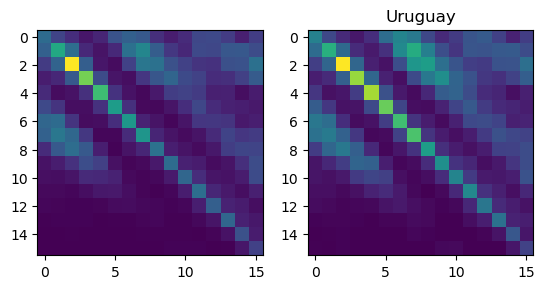

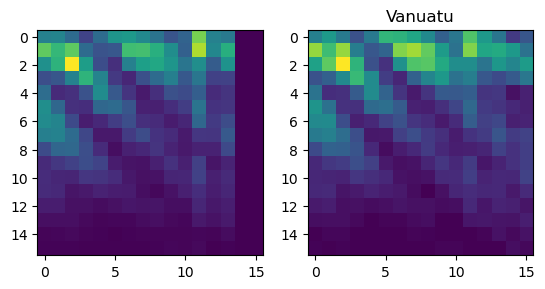

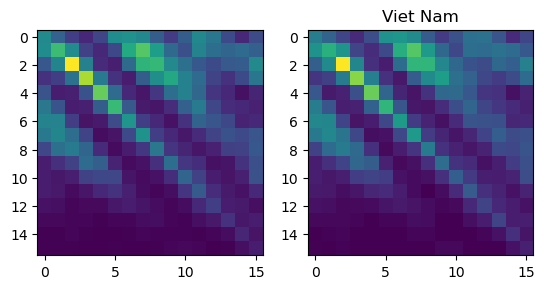

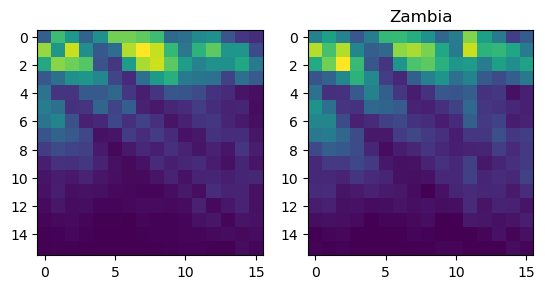

In [73]:
for i in range(140, 152, 2):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    test = home_model(my_dict[names[i]])
    im1 = ax1.imshow(my_dict[names[i]].detach().numpy().reshape(16, 16))
    im2 = ax2.imshow(test.detach().numpy().reshape(16, 16))
    plt.title(names[i])
    plt.show()

In [74]:
matrix = get_conts('Russian Federation')

/home/tsurkis_vi/miniconda3/envs/snakemake/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [75]:
for_nn = transform(matrix.values.T.reshape(-1, 16 * 16))

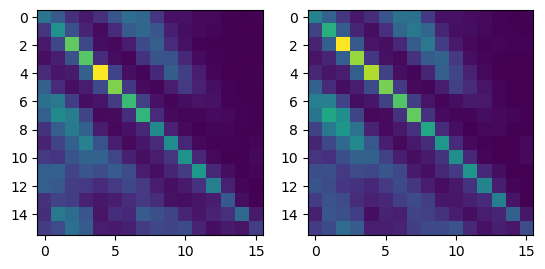

In [76]:
fig, (ax1, ax2) = plt.subplots(1, 2)
test = home_model(for_nn)
im1 = ax1.imshow(matrix)
im2 = ax2.imshow(test.detach().numpy().reshape(16, 16).T)
plt.show()